# Load libraries and set the coordinate system

In [28]:
%pylab inline

import numpy as np
import cvxpy
from cvxpy import Variable, Minimize, sum_squares, norm, Problem, Parameter, mul_elemwise, sum_entries, Constant
from scipy import sparse
import sys, argparse
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import sys

sys.path.append('../../')
from tractionforce.elasticity import *
import gc
from tractionforce.norms import *
from tractionforce.problem import *

from joblib import Parallel, delayed
import multiprocessing

"""
Set up the domain and the grid
"""

N = 120
M = 120

x_obs_positions = np.arange(N)
y_obs_positions = np.arange(M)

dx = abs(x_obs_positions[1]-x_obs_positions[0])
dy = abs(y_obs_positions[1]-y_obs_positions[0])



coords = [[ [x,y] for y in y_obs_positions] for x in x_obs_positions]
coords = np.array([item for sublist in coords for item in sublist])
distances = ((coords[:,0]-25)**2 + (coords[:,1]-25)**2)**0.5


r1 = 1.0/5
r2 = 1.0/6
r3 = 1.0/8
r4 = 1.0/4

c1 = (-1,-1/2.)
c2 = (-5/4.,0)
c3 = (2,1)
c4 = (0,1)

scaling = 20


d1 = ((coords[:,0]-N/2.-c1[0]*scaling)**2 + (coords[:,1]-M/2-c1[1]*scaling)**2)**0.5
d2 = ((coords[:,0]-N/2.-c2[0]*scaling)**2 + (coords[:,1]-M/2-c2[1]*scaling)**2)**0.5
d3 = ((coords[:,0]-N/2.-c3[0]*scaling)**2 + (coords[:,1]-M/2-c3[1]*scaling)**2)**0.5
d4 = ((coords[:,0]-N/2.-c4[0]*scaling)**2 + (coords[:,1]-M/2-c4[1]*scaling)**2)**0.5

f14 = 1e-5
g14 = 1e-5
f12 = 3e-4
g12 = 3e-4
g13 = 8e-5
f13 = 4e-5
g42 = 2e-4

s1_x = -(4./5)**2*f14 -(6/5.)**2*f12 -(8/5.)**2*f13
s1_y = -(4./5)**2*g14 +(6/5.)**2*g12 -(8/5.)**2*g12

s2_x = f12
s2_y= -g12 -g42

s3_x = f13
s3_y = g13

s4_x = f14
s4_y = g14 # add cone



def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['reshape', 'diag', 'log', 'vstack', 'log2', 'norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Generate the stress field

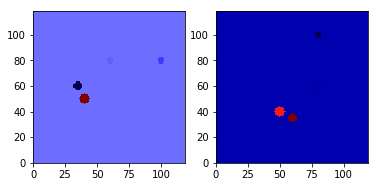

In [29]:
CUTOFF  = 20

in_1 = d1<=r1*scaling
in_2 = d2<=r2*scaling
in_3 = d3<=r3*scaling
in_4 = d4<=r3*scaling

stress_x = np.zeros(coords.shape[0])
stress_y = np.zeros(coords.shape[0])

stress_x[in_1] = s1_x
stress_y[in_1] = s1_y
stress_x[in_2] = s2_x
stress_y[in_2] = s2_y
stress_x[in_3] = s3_x
stress_y[in_3] = s3_y
stress_x[in_4] = s4_x
stress_y[in_4] = s4_y

# add the cone for region 4

plt.subplot(121)
plt.pcolormesh(x_obs_positions,y_obs_positions,stress_x.reshape((M,N)).transpose(),
                           cmap='seismic_r').axes.set_aspect('equal')
plt.subplot(122)
plt.pcolormesh(x_obs_positions,y_obs_positions,stress_y.reshape((M,N)),
                           cmap='seismic_r').axes.set_aspect('equal')



# Generate linear system matrices

In [30]:
G_in_in_xx, G_in_in_xy, G_out_in_xx, G_out_in_xy, G_in_in_yy, G_in_in_yx, G_out_in_yy, G_out_in_yx, Dx, Dy = gen_matrices(x_in,y_in,x_out,y_out,dx,dy,loworder = False)

NameError: name 'x_in' is not defined

In [6]:
# Generate the measured dispalcements

u_in_x = G_in_in_xx.dot(s_x) + G_in_in_xy.dot(s_y)
u_out_x = G_out_in_xx.dot(s_x) + G_out_in_xy.dot(s_y)

u_in_y = G_in_in_yx.dot(s_x) + G_in_in_yy.dot(s_y)
u_out_y = G_out_in_yx.dot(s_x)  + G_out_in_yy.dot(s_y)

u_x = np.zeros(coords.shape[0])
u_x[condition_inside] = u_in_x
u_x[condition_outside] = u_out_x

u_y = np.zeros(coords.shape[0])
u_y[condition_inside] = u_in_y
u_y[condition_outside] = u_out_y


In [7]:
N_SOLUTIONS = 24
gamma_vals = np.logspace(-5, 0, N_SOLUTIONS)


# Coords are 1:100 in each direction
# annulus centered
# inner radius 20
# outer radius 30
# boundary radius 35

gamma = Parameter(sign="positive",value=1)

n_in = len(x_in)
x_center = np.mean(x_in)
y_center = np.mean(y_in)

sigma_xz = Variable(n_in)
sigma_yz = Variable(n_in)
predicted_in_x = G_in_in_xx * sigma_xz + G_in_in_xy * sigma_yz
predicted_out_x = G_out_in_xx * sigma_xz + G_out_in_xy * sigma_yz
predicted_in_y = G_in_in_yx * sigma_xz + G_in_in_yy * sigma_yz
predicted_out_y = G_out_in_yx * sigma_xz + G_out_in_yy * sigma_yz


error = sum_squares(u_in_x - predicted_in_x) + sum_squares(u_out_x - predicted_out_x) + \
    sum_squares(u_in_y - predicted_in_y) + sum_squares(u_out_y - predicted_out_y)

forceconstraints = [sum_entries(sigma_xz)==0, sum_entries(sigma_yz)==0] # add torque-free constraint here
net_torque = sum_entries(mul_elemwise(x_in-x_center,sigma_yz) - mul_elemwise(y_in-y_center,sigma_xz))

torqueconstraints = [net_torque == 0]

constraints = forceconstraints + torqueconstraints
#constraints = []

In [8]:
regularity_penalty = norm(sigma_xz+sigma_yz,p=1)
objective = Minimize(error + gamma*regularity_penalty)
prob = Problem(objective, constraints)

sq_penalty = []
l1_penalty = []
sigma_xz_values = []
sigma_yz_values = []

u_x_values = []
u_y_values = []

In [9]:
num_cores = multiprocessing.cpu_count() - 4

def invert_one(val):
    gamma.value = val
    try:
        prob.solve(verbose= True, max_iters = 50,
                   warm_start=True, solver = cvxpy.CVXOPT,
                   feastol = 1e-6, reltol = 1e-5,
                   abstol = 1e-6)

    except cvxpy.SolverError:
        return None

    sq_penalty.append(error.value)
    l1_penalty.append(regularity_penalty.value)
    sigma_xz_values.append(sigma_xz.value)
    sigma_yz_values.append(sigma_yz.value)

    s_x = np.zeros(coords.shape[0])
    s_y = np.zeros(coords.shape[0])
    
    s_x[condition_inside] = sigma_xz.value.reshape((n_in,))
    s_y[condition_inside] = sigma_yz.value.reshape((n_in,))

    u_x = np.zeros(coords.shape[0])
    u_y = np.zeros(coords.shape[0])
    u_x[condition_inside] = predicted_in_x.value
    u_x[condition_outside] = predicted_out_x.value
    u_y[condition_inside] = predicted_in_y.value
    u_y[condition_outside] = predicted_out_y.value

    return np.array([s_x, s_y]).T, np.array([u_x, u_y]).T, error.value, regularity_penalty.value, val


#results = Parallel(n_jobs=num_cores)(delayed(invert_one)(val) for val in gamma_vals)


In [10]:
force, u, err, reg, val = invert_one(gamma_vals[-1])

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.0000e+00  2e+03  1e+01  2e+00  1e+00
 1: -6.0248e+00 -3.8936e+00  2e+02  2e+00  3e-01  3e+00
 2: -4.1295e-01 -1.6970e-01  1e+00  3e-02  4e-03  3e-01
 3: -3.9245e-02 -1.4468e-02  1e-01  3e-03  4e-04  3e-02
 4:  6.3573e-03  1.0709e-02  2e-02  5e-04  8e-05  5e-03
 5:  1.1672e-02  1.3514e-02  1e-02  2e-04  4e-05  2e-03
 6:  1.5177e-02  1.5656e-02  3e-03  6e-05  1e-05  5e-04
 7:  1.5616e-02  1.5842e-02  2e-03  4e-05  5e-06  2e-04
 8:  1.6054e-02  1.6110e-02  4e-04  9e-06  1e-06  6e-05
 9:  1.6150e-02  1.6160e-02  1e-04  2e-06  3e-07  1e-05
10:  1.6173e-02  1.6174e-02  2e-05  3e-07  5e-08  2e-06
11:  1.6176e-02  1.6176e-02  2e-06  4e-08  6e-09  2e-07
12:  1.6176e-02  1.6176e-02  1e-06  2e-08  3e-09  8e-08
Optimal solution found.


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:22: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:23: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:27: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:28: DeprecationWarning: assignment will raise an error in the future, most likely because your index r

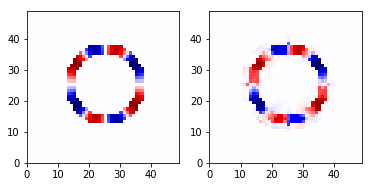

In [11]:
maxval = np.max(np.abs(force))

plt.subplot(121)
plt.pcolormesh(x_obs_positions,y_obs_positions,stress_x.reshape((50,50)).transpose(),
                           cmap='seismic_r',vmin=-maxval,vmax=maxval).axes.set_aspect('equal')

plt.subplot(122)
plt.pcolormesh(x_obs_positions,y_obs_positions,force[:,0].reshape((50,50)).transpose(),
                           cmap='seismic_r',vmin=-maxval,vmax=maxval).axes.set_aspect('equal')
#plt.colorbar()

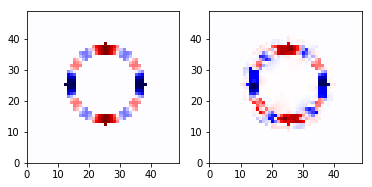

In [12]:
plt.subplot(121)

maxval = np.max(np.abs(stress_y))
plt.pcolormesh(x_obs_positions,y_obs_positions,stress_y.reshape((50,50)).transpose(),
                           cmap='seismic_r',vmin=-maxval, vmax=maxval).axes.set_aspect('equal')

plt.subplot(122)
plt.pcolormesh(x_obs_positions,y_obs_positions,force[:,1].reshape((50,50)).transpose(),
                           cmap='seismic_r',vmin=-maxval, vmax=maxval).axes.set_aspect('equal')
#plt.colorbar()

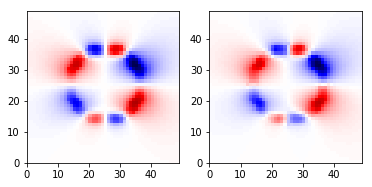

In [13]:
maxval = np.max(np.abs(u_x))

plt.subplot(121)
plt.pcolormesh(x_obs_positions,y_obs_positions,u_x.reshape((50,50)).transpose(),
                           cmap='seismic_r',vmin=-maxval, vmax=maxval).axes.set_aspect('equal')
plt.subplot(122)
plt.pcolormesh(x_obs_positions,y_obs_positions,u[:,0].reshape((50,50)).transpose(),
                           cmap='seismic_r',vmin=-maxval, vmax=maxval).axes.set_aspect('equal')
#plt.colorbar()

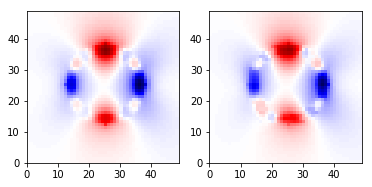

In [14]:
maxval = np.max(np.abs(u_y))

plt.subplot(121)
plt.pcolormesh(x_obs_positions,y_obs_positions,u_y.reshape((50,50)).transpose(),
                           cmap='seismic_r',vmin=-maxval, vmax=maxval).axes.set_aspect('equal')
plt.subplot(122)
plt.pcolormesh(x_obs_positions,y_obs_positions,u[:,1].reshape((50,50)).transpose(),
                           cmap='seismic_r',vmin=-maxval, vmax=maxval).axes.set_aspect('equal')
#plt.colorbar()

In [18]:
sum(force)

-2.0057740190981832e-18